Text Mining project by Patryk Zduńczak for Data Science studies on Warsaw University of Techonology
Source data: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from collections import  Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Przygotowanie danych

In [2]:
data = pd.read_csv("Tweets.csv")

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
data = data.loc[:,['text', 'airline_sentiment']]

In [6]:
data

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


# Głębsze zapoznanie się z danymi

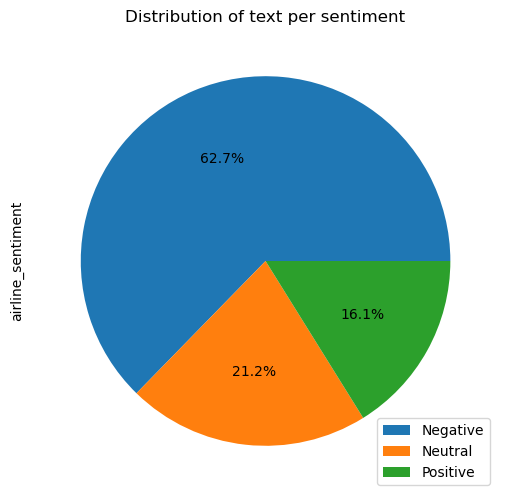

In [13]:
data['airline_sentiment'].value_counts().plot.pie(figsize=(6,6),title="Distribution of text per sentiment",labels=['','',''],autopct='%1.1f%%')
labels=["Negative","Neutral","Positive"]
plt.legend(labels,loc=4)
plt.gca().set_aspect('equal')

Zliczenie słów bez stopwordów

In [10]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

corpus = []
for word in data.text.str.split():
    corpus.extend(word)
counter = Counter(corpus)

most = counter.most_common()

x = []
y = []
for word, count in most[:70]:
    if word.lower() not in stop and word not in ['@united','@AmericanAir', "@USAirways",'@SouthwestAir', '@JetBlue']:
        x.append(word)
        y.append(count)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patryk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<AxesSubplot:>

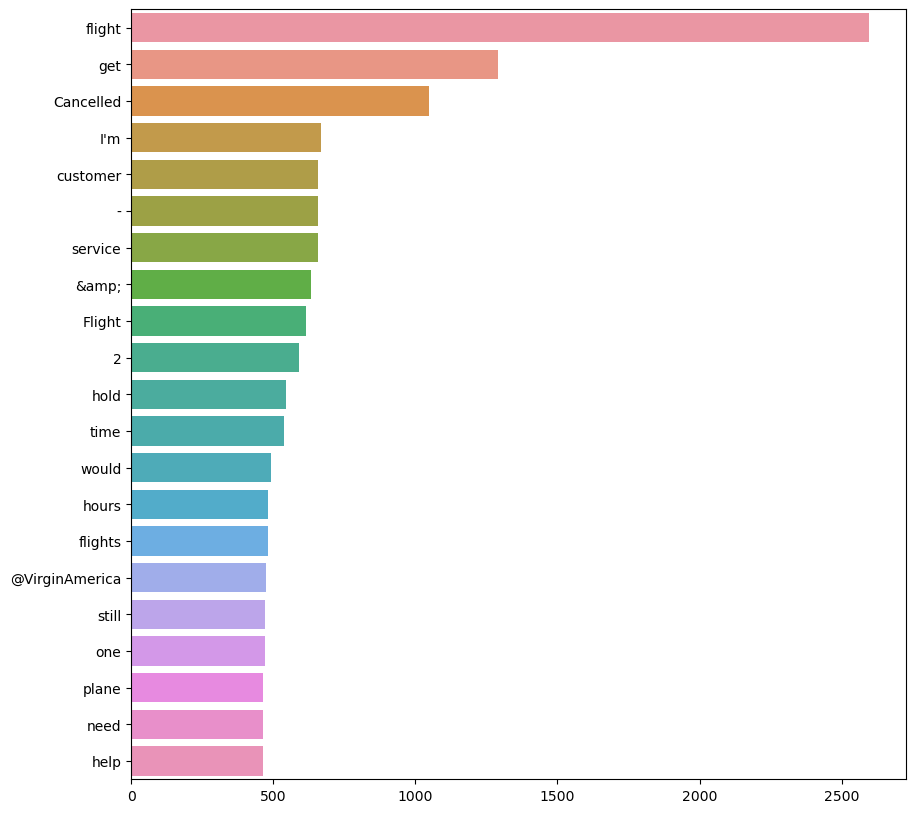

In [14]:
plt.figure(figsize=(10,10))
sns.barplot(x=y, y=x)


Usunięcie wyrazen - REGEX

In [15]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [16]:
data["text_regex"] = data['text'].apply(preprocessor)

In [17]:
data
#Usunięcie znaków specjalnych dla Twittera ma znaczenie pod kątem oznaczeń marki i uytkowników

,text,airline_sentiment,text_regex
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica what dhepburn said
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus you ve added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica i didn t today must mean i need...
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica it s really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica and it s a really big bad thing...
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,americanair thank you we got on a different f...
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,americanair leaving over 20 minutes late flig...
14637,@AmericanAir Please bring American Airlines to...,neutral,americanair please bring american airlines to...
14638,"@AmericanAir you have my money, you change my ...",negative,americanair you have my money you change my f...


Tokenizacja

In [18]:
tqdm.pandas()
data['text_tokenized'] = data["text_regex"].progress_apply(word_tokenize)

100%|██████████| 14640/14640 [00:01<00:00, 12285.64it/s]


In [19]:
data

,text,airline_sentiment,text_regex,text_tokenized
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica what dhepburn said,"[virginamerica, what, dhepburn, said]"
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus you ve added commercials t...,"[virginamerica, plus, you, ve, added, commerci..."
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica i didn t today must mean i need...,"[virginamerica, i, didn, t, today, must, mean,..."
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica it s really aggressive to blast...,"[virginamerica, it, s, really, aggressive, to,..."
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica and it s a really big bad thing...,"[virginamerica, and, it, s, a, really, big, ba..."
...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,americanair thank you we got on a different f...,"[americanair, thank, you, we, got, on, a, diff..."
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,americanair leaving over 20 minutes late flig...,"[americanair, leaving, over, 20, minutes, late..."
14637,@AmericanAir Please bring American Airlines to...,neutral,americanair please bring american airlines to...,"[americanair, please, bring, american, airline..."
14638,"@AmericanAir you have my money, you change my ...",negative,americanair you have my money you change my f...,"[americanair, you, have, my, money, you, chang..."


Czyszczenie tekstu ze stopwordów.

In [20]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patryk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def preprocessor_sw(text):
    text_no_sw = []
    for word in text:
        if word in stop:
            continue
        else:
            text_no_sw.append(word)
    return text_no_sw

In [22]:
data["text_tokenized_no_sw"] = data['text_tokenized'].apply(preprocessor_sw)

In [23]:
data

,text,airline_sentiment,text_regex,text_tokenized,text_tokenized_no_sw
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica what dhepburn said,"[virginamerica, what, dhepburn, said]","[virginamerica, dhepburn, said]"
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus you ve added commercials t...,"[virginamerica, plus, you, ve, added, commerci...","[virginamerica, plus, added, commercials, expe..."
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica i didn t today must mean i need...,"[virginamerica, i, didn, t, today, must, mean,...","[virginamerica, today, must, mean, need, take,..."
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica it s really aggressive to blast...,"[virginamerica, it, s, really, aggressive, to,...","[virginamerica, really, aggressive, blast, obn..."
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica and it s a really big bad thing...,"[virginamerica, and, it, s, a, really, big, ba...","[virginamerica, really, big, bad, thing]"
...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,americanair thank you we got on a different f...,"[americanair, thank, you, we, got, on, a, diff...","[americanair, thank, got, different, flight, c..."
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,americanair leaving over 20 minutes late flig...,"[americanair, leaving, over, 20, minutes, late...","[americanair, leaving, 20, minutes, late, flig..."
14637,@AmericanAir Please bring American Airlines to...,neutral,americanair please bring american airlines to...,"[americanair, please, bring, american, airline...","[americanair, please, bring, american, airline..."
14638,"@AmericanAir you have my money, you change my ...",negative,americanair you have my money you change my f...,"[americanair, you, have, my, money, you, chang...","[americanair, money, change, flight, answer, p..."


Stemming i Lematyzacja

In [24]:
porter = PorterStemmer()

In [25]:
def tokenizer_porter(tokens):
    return [porter.stem(token) for token in tokens]

In [26]:
data["text_stem_with_sw"] = data["text_tokenized"].progress_apply(tokenizer_porter)

100%|██████████| 14640/14640 [00:03<00:00, 4784.69it/s]


In [27]:
data["text_stem_no_sw"] = data["text_tokenized_no_sw"].progress_apply(tokenizer_porter)

100%|██████████| 14640/14640 [00:02<00:00, 6711.70it/s]


In [28]:
data

,text,airline_sentiment,text_regex,text_tokenized,text_tokenized_no_sw,text_stem_with_sw,text_stem_no_sw
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica what dhepburn said,"[virginamerica, what, dhepburn, said]","[virginamerica, dhepburn, said]","[virginamerica, what, dhepburn, said]","[virginamerica, dhepburn, said]"
1,@VirginAmerica plus you've added commercials t...,positive,virginamerica plus you ve added commercials t...,"[virginamerica, plus, you, ve, added, commerci...","[virginamerica, plus, added, commercials, expe...","[virginamerica, plu, you, ve, ad, commerci, to...","[virginamerica, plu, ad, commerci, experi, tacki]"
2,@VirginAmerica I didn't today... Must mean I n...,neutral,virginamerica i didn t today must mean i need...,"[virginamerica, i, didn, t, today, must, mean,...","[virginamerica, today, must, mean, need, take,...","[virginamerica, i, didn, t, today, must, mean,...","[virginamerica, today, must, mean, need, take,..."
3,@VirginAmerica it's really aggressive to blast...,negative,virginamerica it s really aggressive to blast...,"[virginamerica, it, s, really, aggressive, to,...","[virginamerica, really, aggressive, blast, obn...","[virginamerica, it, s, realli, aggress, to, bl...","[virginamerica, realli, aggress, blast, obnoxi..."
4,@VirginAmerica and it's a really big bad thing...,negative,virginamerica and it s a really big bad thing...,"[virginamerica, and, it, s, a, really, big, ba...","[virginamerica, really, big, bad, thing]","[virginamerica, and, it, s, a, realli, big, ba...","[virginamerica, realli, big, bad, thing]"
...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,americanair thank you we got on a different f...,"[americanair, thank, you, we, got, on, a, diff...","[americanair, thank, got, different, flight, c...","[americanair, thank, you, we, got, on, a, diff...","[americanair, thank, got, differ, flight, chic..."
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,americanair leaving over 20 minutes late flig...,"[americanair, leaving, over, 20, minutes, late...","[americanair, leaving, 20, minutes, late, flig...","[americanair, leav, over, 20, minut, late, fli...","[americanair, leav, 20, minut, late, flight, w..."
14637,@AmericanAir Please bring American Airlines to...,neutral,americanair please bring american airlines to...,"[americanair, please, bring, american, airline...","[americanair, please, bring, american, airline...","[americanair, pleas, bring, american, airlin, ...","[americanair, pleas, bring, american, airlin, ..."
14638,"@AmericanAir you have my money, you change my ...",negative,americanair you have my money you change my f...,"[americanair, you, have, my, money, you, chang...","[americanair, money, change, flight, answer, p...","[americanair, you, have, my, money, you, chang...","[americanair, money, chang, flight, answer, ph..."


# Podział na dane testowe i treningowe


Dla danych bez stopwords

In [36]:
X_data_tok_no_sw = data["text_tokenized_no_sw"].copy()
y_data = data["airline_sentiment"].copy()

In [37]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_data_tok_no_sw, y_data, test_size=0.33, random_state=random_state)

In [38]:
train_idx = X_train.index.tolist()
test_idx = X_test.index.tolist()

# Tworzenie modeli

In [39]:
### Nasze dane są już przygotowane i stokenizowane, dlatego CountVectorizer nie musi już tego robić. 
### By temu zapobiec używamy funkcji do_nothing

def do_nothing(tokens):
    return tokens

bow_count = CountVectorizer(tokenizer=do_nothing,
                             preprocessor=None,
                             lowercase=False)

In [40]:
bow_count

CountVectorizer(lowercase=False,
                tokenizer=<function do_nothing at 0x7ff31aad8940>)

In [44]:
### Użyto .fit_transform
X_train_bow_count = bow_count.fit_transform(X_train)
### UWAGA!!! Użyto tylko .transform
X_test_bow_count = bow_count.transform(X_test)

/Users/patryk/opt/anaconda3/envs/TM/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MultinomialNB

In [42]:
clf = MultinomialNB()
clf.fit(X_train_bow_count, y_train)

MultinomialNB()

In [45]:
y_train_pred = clf.predict(X_train_bow_count)
y_test_pred_multiNB = clf.predict(X_test_bow_count)
multiNB_bow_train_score = accuracy_score(y_train, y_train_pred)
multiNB_bow_test_score = accuracy_score(y_test, y_test_pred_multiNB)
print(f"multiNB_bow_score na zbiorze treningowym: {multiNB_bow_train_score}")
print(f"multiNB_bow_score na zbiorze testowym: {multiNB_bow_test_score}")

multiNB_bow_score na zbiorze treningowym: 0.8527732463295269
multiNB_bow_score na zbiorze testowym: 0.7727649006622517


Regresja logistyczna

In [46]:
clf = LogisticRegression()
clf.fit(X_train_bow_count, y_train)

/Users/patryk/opt/anaconda3/envs/TM/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
y_train_pred = clf.predict(X_train_bow_count)
y_test_pred_LogReg = clf.predict(X_test_bow_count)
LogReg_bow_train_score = accuracy_score(y_train, y_train_pred)
LogReg_bow_test_score = accuracy_score(y_test, y_test_pred_LogReg)
print(f"LogReg_bow_score na zbiorze treningowym: {LogReg_bow_train_score}")
print(f"LogReg_bow_score na zbiorze testowym: {LogReg_bow_test_score}")

LogReg_bow_score na zbiorze treningowym: 0.9528955954323002
LogReg_bow_score na zbiorze testowym: 0.7934602649006622


# Podsumowanie najlepszego modelu -> Regresji logistycznej

In [48]:
logReg_class_report = classification_report(y_test, y_test_pred_LogReg)
print(logReg_class_report)

              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      3085
     neutral       0.62      0.55      0.58       984
    positive       0.77      0.69      0.72       763

    accuracy                           0.79      4832
   macro avg       0.74      0.71      0.73      4832
weighted avg       0.79      0.79      0.79      4832



In [50]:
cf_matrix = confusion_matrix(y_test, y_test_pred_LogReg)
print(cf_matrix)

[[2767  242   76]
 [ 358  544   82]
 [ 146   94  523]]


Text(50.722222222222214, 0.5, 'Actual')

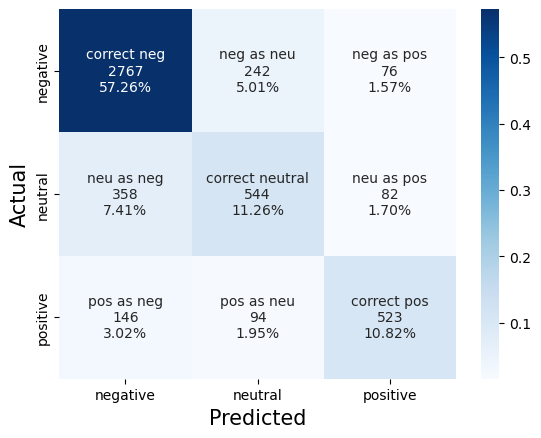

In [51]:
group_names = ['correct neg','neg as neu','neg as pos','neu as neg', 'correct neutral', 'neu as pos', 'pos as neg', 'pos as neu', 'correct pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

categories = ['negative', 'neutral', 'positive']

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt='',
             cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15)